In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
paste('marine',0:4,sep='')

[1] "marine0" "marine1" "marine2" "marine3" "marine4"

In [4]:


d1 = data.table(expand.grid(tool=correct_taxonomy_tools, sample=paste('marine',0:4,sep=''), known=c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)))
d1[, method := 'relabund']
d1[tool=='kraken', method := 'reads_wise']
d1[tool=='kaiju', method := 'reads_wise']
d1[tool=='metabuli', method := 'reads_wise']
d1[1:3]

tool,sample,known,method
<fct>,<fct>,<dbl>,<chr>
singlem,marine0,0,relabund
metaphlan,marine0,0,relabund
kraken,marine0,0,reads_wise


In [5]:
# df = pl.read_csv('output_*/opal/known*/*.opal_report')
d2 = d1[, fread(paste('output_',tool,sep='','/opal/known',known,'/',sample,'.opal_report')), by=list(tool,sample,known)]
d2[1:3]

tool,sample,known,tool,rank,metric,sample,value
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [6]:
setnames(d2, c('tool','sample','known','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, sample, known, rank, metric, value)]

In [7]:
fwrite(d3, 'accuracy_results.csv')

In [8]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 1925    6

tool,sample,known,rank,metric,value
<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>
singlem,marine0,0,kingdom,Bray-Curtis distance,0.001875821
singlem,marine0,0,phylum,Bray-Curtis distance,0.015305700
singlem,marine0,0,class,Bray-Curtis distance,0.017625411
singlem,marine0,0,order,Bray-Curtis distance,0.025995859
singlem,marine0,0,family,Bray-Curtis distance,0.031060594
singlem,marine0,0,genus,Bray-Curtis distance,0.041240767
singlem,marine0,0,species,Bray-Curtis distance,0.147113779
metaphlan,marine0,0,kingdom,Bray-Curtis distance,0.002753305
metaphlan,marine0,0,phylum,Bray-Curtis distance,0.111757008


In [9]:
bc_medians = bc[,.(median=median(value)), by=.(tool, known, rank)]
bc_medians[1:10]

tool,known,rank,median
<fct>,<dbl>,<chr>,<dbl>
singlem,0,kingdom,0.001761447
singlem,0,phylum,0.015305700
singlem,0,class,0.017625411
singlem,0,order,0.025995859
singlem,0,family,0.031060594
singlem,0,genus,0.044310329
singlem,0,species,0.138570377
metaphlan,0,kingdom,0.001601680
metaphlan,0,phylum,0.052680819


Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


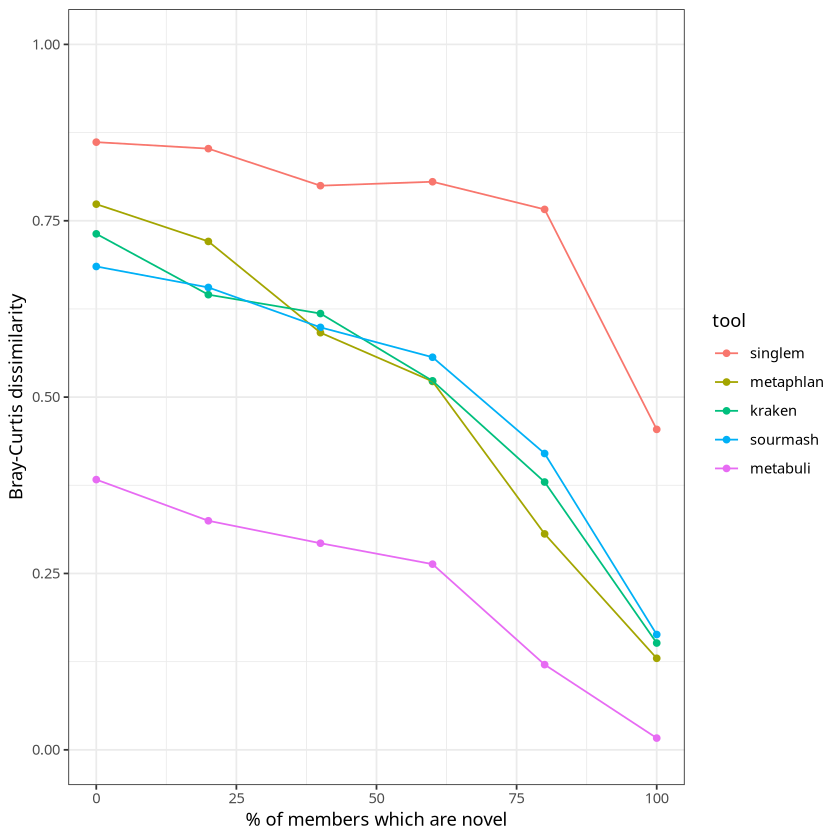

In [10]:

qplot(data=bc_medians[rank=='species' & tool %in% correct_taxonomy_tools & known %in% c(0,20,40,60,80,100)], known, 1-median, colour=tool)+geom_line()+ylab('Bray-Curtis dissimilarity')+xlab('% of members which are novel')+ylim(0,1)

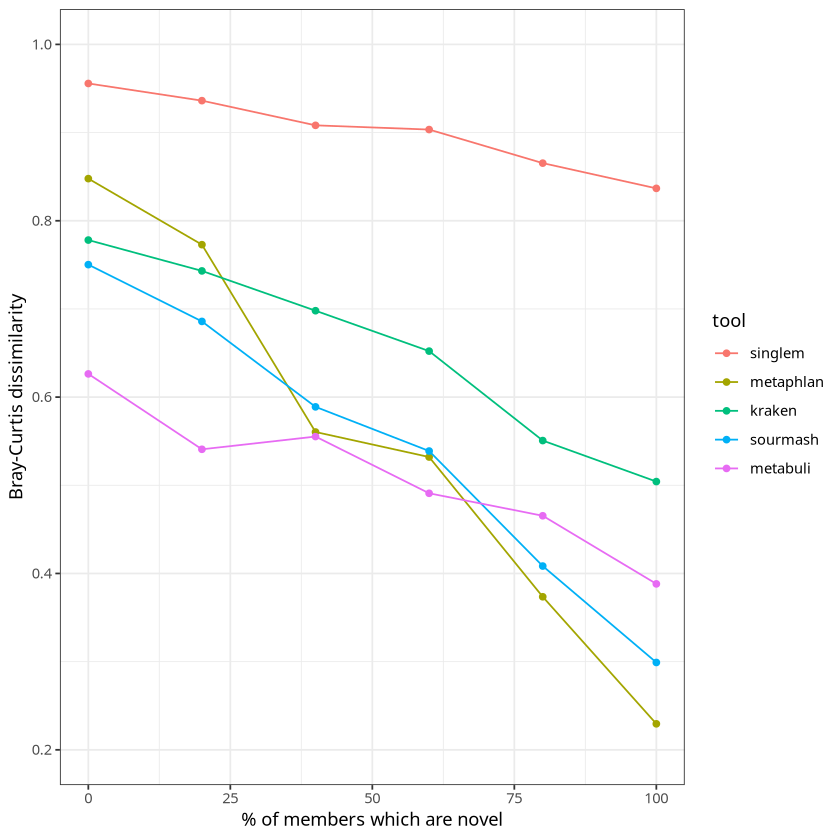

In [11]:
# no legend
# qplot(data=bc_medians[rank=='genus' & tool %in% correct_taxonomy_tools], known, 1-median, colour=tool)+geom_line()+ylab('Bray-Curtis dissimilarity')+xlab('% of members which are novel')+ylim(0.2,1)
qplot(data=bc_medians[rank=='genus' & tool %in% correct_taxonomy_tools & known %in% c(0,20,40,60,80,100)], known, 1-median, colour=tool)+geom_line()+ylab('Bray-Curtis dissimilarity')+xlab('% of members which are novel')+ylim(0.2,1)

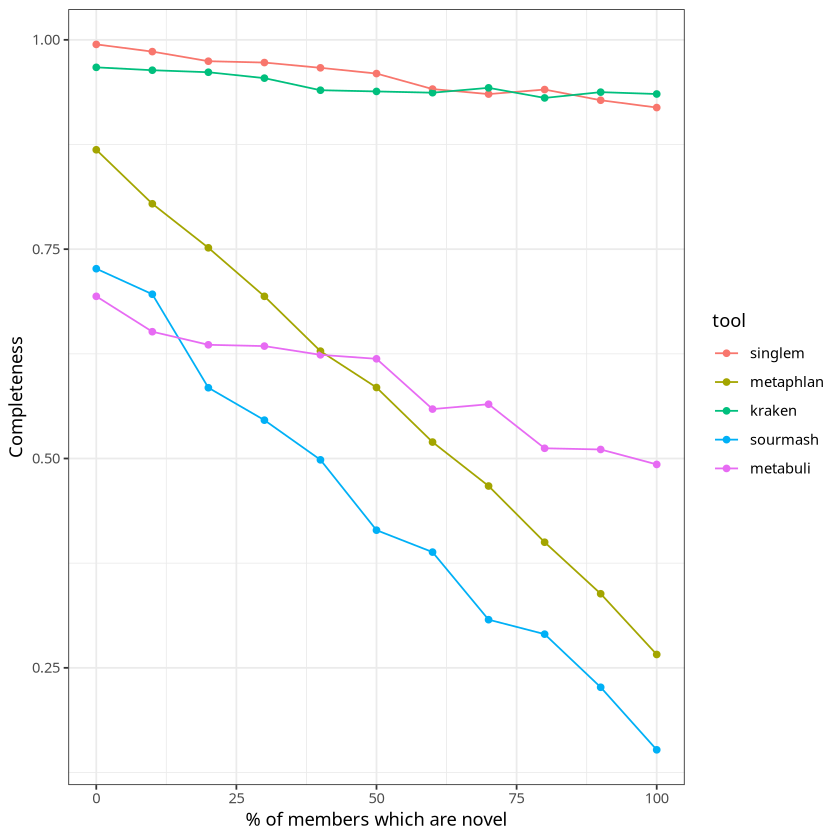

In [12]:
qplot(data=d3[metric=='Completeness'][,.(median=median(value)), by=.(tool, known, rank)][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('Completeness')+xlab('% of members which are novel')

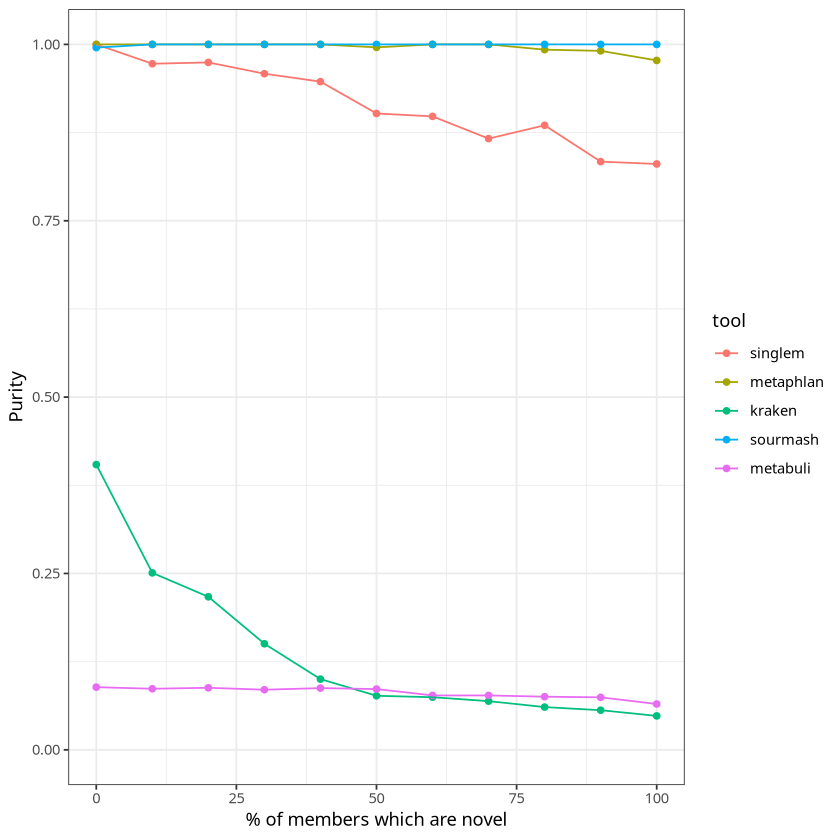

In [13]:
qplot(data=d3[metric=='Purity'][,.(median=median(value)), by=.(tool, known, rank)][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('Purity')+xlab('% of members which are novel')+ylim(0,1)

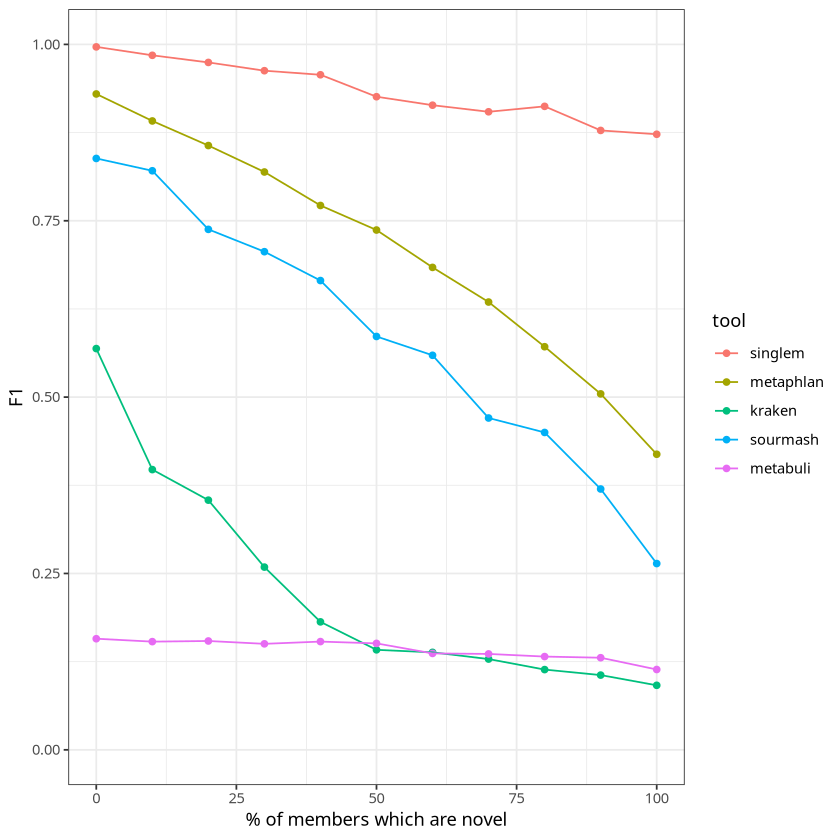

In [14]:
qplot(data=d3[metric=='F1 score'][,.(median=median(value)), by=.(tool, known, rank)][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('F1')+xlab('% of members which are novel')+ylim(0,1)

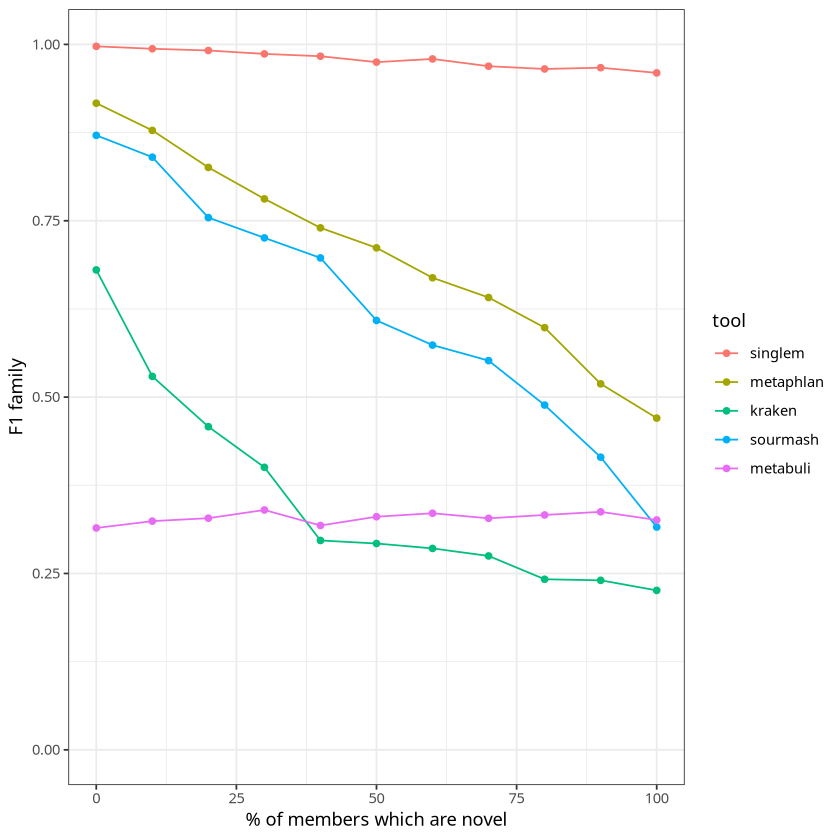

In [15]:
qplot(data=d3[metric=='F1 score'][,.(median=median(value)), by=.(tool, known, rank)][rank=='family' & tool %in% correct_taxonomy_tools], known, median, colour=tool)+geom_line()+ylab('F1 family')+xlab('% of members which are novel')+ylim(0,1)

In [16]:
# How much better when novelty was at its maximum?
second = min(d3[tool != 'singlem'][rank=='genus' & metric=='Bray-Curtis distance' & known==100][,.(median(value)),by=tool]$V1)
singlem = min(d3[tool == 'singlem'][rank=='genus' & metric=='Bray-Curtis distance' & known==100][,.(median(value)),by=tool]$V1)
second
singlem
second - singlem

[1] 0.4958031

[1] 0.1632691

[1] 0.3325339

In [17]:
second = max(d3[tool != 'singlem'][rank=='genus' & metric=='F1 score' & known==100][,.(median(value)),by=tool]$V1)
singlem = max(d3[tool == 'singlem'][rank=='genus' & metric=='F1 score' & known==100][,.(median(value)),by=tool]$V1)
second
singlem
second - singlem

[1] 0.4189944

[1] 0.8726115

[1] -0.4536171

# Write overall results for supp data

In [18]:
d3w = d3[tool!='Gold standard'][,.(value=mean(value)), by=list(tool,metric,rank,known)]
d3w[, rank := factor(rank, levels=c('species','genus','family','order','class','phylum','kingdom'))]
d3w[, tool2 := name_to_publication_name(tool, correct_taxonomy_only = T)]
# dcast(d3w, rank+tool2+known~metric, value.var='value')
fwrite(x=dcast(d3w, rank+tool2+known~metric, value.var='value'), file='supp_data1.csv')